In [1]:
# Integrar y verificar todo lo generado en E2:
# - Consistencias entre processed y features
# - Métricas clave (cobertura OOV, densidad TF-IDF, truncado BERT)
# - 4–5 gráficos globales
# Exporta informes a reports/06_*.*

#### ***Imports y config***

In [2]:
from pathlib import Path
import json, numpy as np, pandas as pd
import matplotlib.pyplot as plt
from scipy import sparse

pd.set_option("display.max_colwidth", 120)

#### ***Rutas y detección de artefactos***

In [3]:
def find_root():
    p = Path.cwd()
    for c in [p, *p.parents]:
        if (c/"data").exists() and (c/"notebooks").exists():
            return c
    raise FileNotFoundError("No encuentro la raíz del repo.")

ROOT = find_root()
PROC = ROOT/"data"/"processed"
FEAT = ROOT/"features"
REPO = ROOT/"reports"
REPO.mkdir(parents=True, exist_ok=True)

paths = {
    "proc_easy_train": PROC/"easy"/"train"/"sentences.jsonl",
    "proc_easy_val":   PROC/"easy"/"validation"/"sentences.jsonl",
    "tfidf_json":      FEAT/"tfidf"/"tfidf_resumen.json",
    "w2v_json":        FEAT/"embeddings_static"/"w2v_resumen.json",
    "ctx_json":        FEAT/"embeddings_contextual"/"contextual_resumen.json",
    "Xtr_w":           FEAT/"tfidf"/"word"/"X_train_word.npz",
    "Xtr_c":           FEAT/"tfidf"/"char"/"X_train_char.npz",
    "kv":              FEAT/"embeddings_static"/"w2v.kv",
    "C_tr":            FEAT/"embeddings_contextual"/"C_train.npy",
}

print({k: p.exists() for k,p in paths.items()})

{'proc_easy_train': True, 'proc_easy_val': True, 'tfidf_json': True, 'w2v_json': True, 'ctx_json': True, 'Xtr_w': True, 'Xtr_c': True, 'kv': True, 'C_tr': True}


#### ***Carga de resúmenes y fallback***

In [4]:
def safe_json(p: Path):
    if p.exists():
        return json.loads(p.read_text(encoding="utf-8"))
    return {}

sum_tfidf = safe_json(paths["tfidf_json"])
sum_w2v   = safe_json(paths["w2v_json"])
sum_ctx   = safe_json(paths["ctx_json"])

# Si faltan shapes, calcúlalos rápido
if not sum_tfidf:
    Xw = sparse.load_npz(paths["Xtr_w"]) if paths["Xtr_w"].exists() else None
    Xc = sparse.load_npz(paths["Xtr_c"]) if paths["Xtr_c"].exists() else None
    sum_tfidf = {
        "word": {"shape_train": Xw.shape if Xw is not None else None,
                 "nnz_train": int(Xw.nnz) if Xw is not None else None},
        "char": {"shape_train": Xc.shape if Xc is not None else None,
                 "nnz_train": int(Xc.nnz) if Xc is not None else None},
    }

# Procesed: carga sólo lo necesario para métricas globales
def load_processed():
    dfs = []
    for lvl in ["easy","medium","hard"]:
        for split in ["train","validation"]:
            p = PROC/lvl/split/"sentences.jsonl"
            if p.exists():
                df = pd.read_json(p, lines=True)
                df["level"]=lvl; df["split"]=split
                dfs.append(df[["level","split","doc_id","sent_id","n_tokens"]])
    return pd.concat(dfs, ignore_index=True)

dfp = load_processed()

#### ***Verificaciones cruzadas***

In [5]:
checks = {}

# 5.1 Consistencia processed por split
checks["frases_por_split"] = (
    dfp.groupby(["level","split"])["sent_id"].count().unstack().fillna(0).astype(int)
)

# 5.2 Densidad TF-IDF (si existen)
def densidad(n_shape, nnz):
    if not n_shape or nnz is None: return None
    m, n = n_shape
    return round(nnz/(m*n), 6)

dens_word = densidad(tuple(sum_tfidf["word"]["shape_train"]) if sum_tfidf["word"]["shape_train"] else None,
                     sum_tfidf["word"].get("nnz_train"))
dens_char = densidad(tuple(sum_tfidf["char"]["shape_train"]) if sum_tfidf["char"]["shape_train"] else None,
                     sum_tfidf["char"].get("nnz_train"))

# 5.3 OOV por nivel con W2V (si hay kv)
try:
    from gensim.models import KeyedVectors
    kv = KeyedVectors.load(str(paths["kv"])) if paths["kv"].exists() else None
except Exception:
    kv = None

def cobertura_por_nivel(df, kv):
    if kv is None: return None
    def cov(gr):
        toks = gr["n_tokens"].sum()  # no tenemos texto, estimar por n_tokens
        # Sin texto no podemos tokenizar; marcamos None
        return None
    # Nota: para OOV real necesitarías `text_norm`. Si quieres, carga ese campo aquí.
    return None

# 5.4 Truncado BERT
trunc_train = sum_ctx.get("trunc_ratio_train")
trunc_val   = sum_ctx.get("trunc_ratio_val")

checks["dens_tfidf"] = {"word": dens_word, "char": dens_char}
checks["trunc_ctx"]  = {"train": trunc_train, "val": trunc_val}
checks

{'frases_por_split': split   train  validation
 level                    
 easy    52701       11146
 hard    55515       11649
 medium  63386       13763,
 'dens_tfidf': {'word': 0.000302, 'char': 0.00197},
 'trunc_ctx': {'train': 0.0152, 'val': 0.015}}

#### ***Gráficos globales***

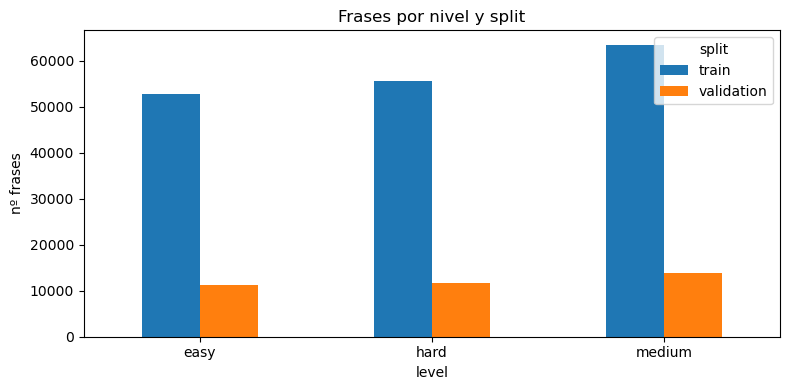

<Figure size 800x400 with 0 Axes>

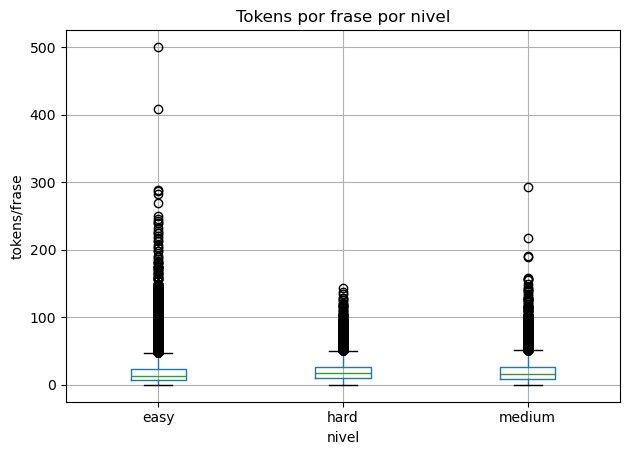

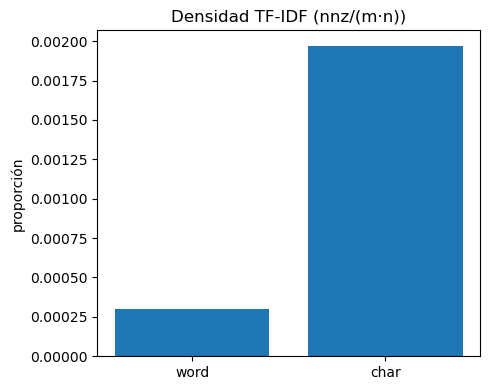

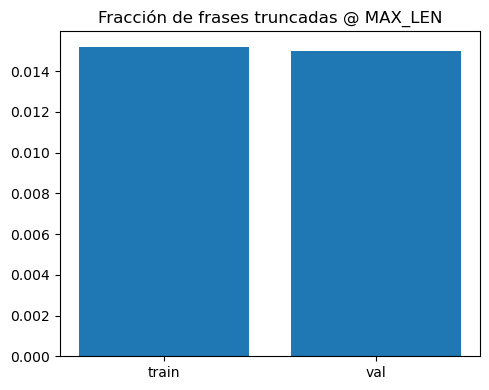

In [6]:
# 6.1 Barras: frases por nivel y split
cnt = dfp.groupby(["level","split"])["sent_id"].count().reset_index(name="n_frases")
pv = cnt.pivot(index="level", columns="split", values="n_frases").fillna(0)
ax = pv.plot(kind="bar", rot=0, figsize=(8,4))
ax.set_ylabel("nº frases"); ax.set_title("Frases por nivel y split")
plt.tight_layout(); plt.savefig(REPO/"06_frases_por_nivel_split.png", dpi=150); plt.show()

# 6.2 Boxplot: tokens por frase por nivel
plt.figure(figsize=(8,4))
dfp.boxplot(column="n_tokens", by="level")
plt.suptitle(""); plt.title("Tokens por frase por nivel")
plt.xlabel("nivel"); plt.ylabel("tokens/frase")
plt.tight_layout(); plt.savefig(REPO/"06_box_tokens_por_nivel.png", dpi=150); plt.show()

# 6.3 Densidad TF-IDF
labels = ["word","char"]; vals = [checks["dens_tfidf"]["word"], checks["dens_tfidf"]["char"]]
plt.figure(figsize=(5,4))
plt.bar(labels, [v if v is not None else 0 for v in vals])
plt.title("Densidad TF-IDF (nnz/(m·n))"); plt.ylabel("proporción")
plt.tight_layout(); plt.savefig(REPO/"06_densidad_tfidf.png", dpi=150); plt.show()

# 6.4 Truncado BERT
if checks["trunc_ctx"]["train"] is not None:
    plt.figure(figsize=(5,4))
    plt.bar(["train","val"], [checks["trunc_ctx"]["train"], checks["trunc_ctx"]["val"]])
    plt.title("Fracción de frases truncadas @ MAX_LEN")
    plt.tight_layout(); plt.savefig(REPO/"06_truncado_bert.png", dpi=150); plt.show()